In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pprint

Pretty printing has been turned OFF


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sys

In [4]:
sys.path.append('../codes')

In [5]:
from VMSfunctions.VMS import *
from VMSfunctions.Common import Peak

# Generate Fake Peaks

In [6]:
from VMSfunctions.Common import load_obj
from VMSfunctions.DataGenerator import PeakSampler

In [7]:
m = Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',5,2)

# Basic Scanning Methods

In [8]:
test1_result_basic = []
test2_result_basic = []
test3_result_basic = []
test4_result_basic = []
test5_result_basic = []
test6_result_basic = []

for i in range(0,100):
    Data_test1=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',10,1)
    Data_test2=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',50,1)
    Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',100,1)
    test1=Dia_Basic(Data_test1,10,"even")
    test2=Dia_Basic(Data_test1,10,"percentile")
    test3=Dia_Basic(Data_test2,10,"even")
    test4=Dia_Basic(Data_test2,10,"percentile")
    test5=Dia_Basic(Data_test3,10,"even")
    test6=Dia_Basic(Data_test3,10,"percentile")
    test1_result_basic.append(test1.entropy())
    test2_result_basic.append(test2.entropy())
    test3_result_basic.append(test3.entropy())
    test4_result_basic.append(test4.entropy())
    test5_result_basic.append(test5.entropy())
    test6_result_basic.append(test6.entropy())
    
test_result_basic = [test1_result_basic,test2_result_basic,test3_result_basic,test4_result_basic,test5_result_basic,test6_result_basic]

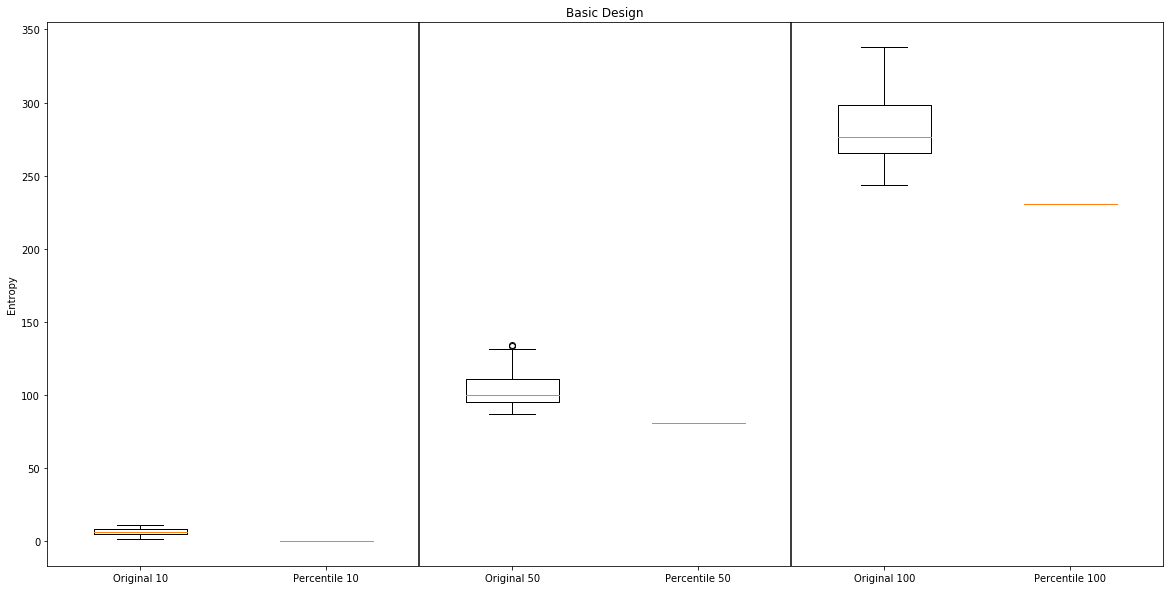

In [9]:
plt.figure(figsize=(20,10))
plt.axvline(x=2.5,color='k')
plt.axvline(x=4.5,color='k')
plt.boxplot(test_result_basic)
plt.ylabel("Entropy")
plt.title("Basic Design")
plt.xticks([1,2,3,4,5,6],["Original 10","Percentile 10","Original 50","Percentile 50","Original 100","Percentile 100"])
plt.show()

# Kaufmann Tree Scanning Method

In [10]:
test1_result_tree = []
test2_result_tree = []
test3_result_tree = []
test4_result_tree = []
test5_result_tree = []
test6_result_tree = []

for i in range(0,100):
    Data_test1=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',50,1)
    Data_test2=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',100,1)
    Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',200,1)
    test1=Dia_Kaufmann(Data_test1,64,"even","tree")
    test2=Dia_Kaufmann(Data_test1,64,"percentile","tree")
    test3=Dia_Kaufmann(Data_test2,64,"even","tree")
    test4=Dia_Kaufmann(Data_test2,64,"percentile","tree")
    test5=Dia_Kaufmann(Data_test3,64,"even","tree")
    test6=Dia_Kaufmann(Data_test3,64,"percentile","tree")
    test1_result_tree.append(test1.entropy(6)[-1])
    test2_result_tree.append(test2.entropy(6)[-1])
    test3_result_tree.append(test3.entropy(6)[-1])
    test4_result_tree.append(test4.entropy(6)[-1])
    test5_result_tree.append(test5.entropy(6)[-1])
    test6_result_tree.append(test6.entropy(6)[-1])
    
test_result_tree = [test1_result_tree,test2_result_tree,test3_result_tree,test4_result_tree,test5_result_tree,test6_result_tree]

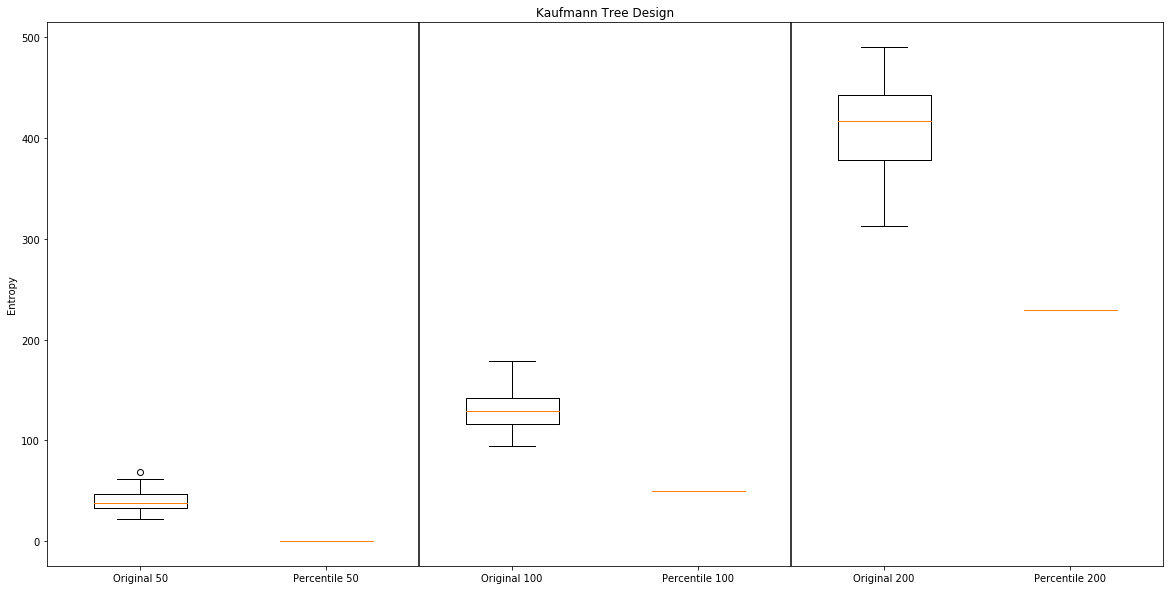

In [11]:
plt.figure(figsize=(20,10))
plt.axvline(x=2.5,color='k')
plt.axvline(x=4.5,color='k')
plt.boxplot(test_result_tree)
plt.ylabel("Entropy")
plt.title("Kaufmann Tree Design")
plt.xticks([1,2,3,4,5,6],["Original 50","Percentile 50","Original 100","Percentile 100","Original 200","Percentile 200"])
plt.show()

# Kaufmann Nested Scanning Method

In [12]:
test1_result_nested = []
test2_result_nested = []
test3_result_nested = []
test4_result_nested = []
test5_result_nested = []
test6_result_nested = []

for i in range(0,100):
    Data_test1=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',50,1)
    Data_test2=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',100,1)
    Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',200,1)
    test1=Dia_Kaufmann(Data_test1,64,"even","nested")
    test2=Dia_Kaufmann(Data_test1,64,"percentile","nested")
    test3=Dia_Kaufmann(Data_test2,64,"even","nested")
    test4=Dia_Kaufmann(Data_test2,64,"percentile","nested")
    test5=Dia_Kaufmann(Data_test3,64,"even","nested")
    test6=Dia_Kaufmann(Data_test3,64,"percentile","nested")
    test1_result_nested.append(test1.entropy(8)[-1])
    test2_result_nested.append(test2.entropy(8)[-1])
    test3_result_nested.append(test3.entropy(8)[-1])
    test4_result_nested.append(test4.entropy(8)[-1])
    test5_result_nested.append(test5.entropy(8)[-1])
    test6_result_nested.append(test6.entropy(8)[-1])
    


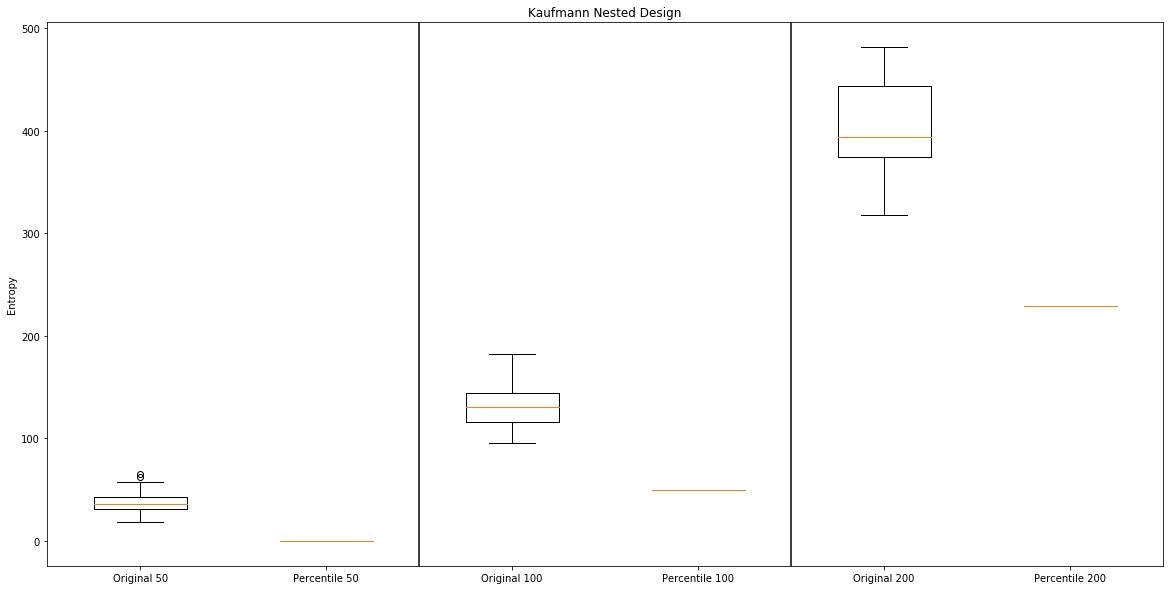

In [13]:
test_result_nested = [test1_result_nested,test2_result_nested,test3_result_nested,test4_result_nested,test5_result_nested,test6_result_nested]

plt.figure(figsize=(20,10))
plt.axvline(x=2.5,color='k')
plt.axvline(x=4.5,color='k')
plt.boxplot(test_result_nested)
plt.ylabel("Entropy")
plt.title("Kaufmann Nested Design")
plt.xticks([1,2,3,4,5,6],["Original 50","Percentile 50","Original 100","Percentile 100","Original 200","Percentile 200"])
plt.show()

# Kaufmann Tree Method Comparisons

[<matplotlib.lines.Line2D object at 0x0000019BB6FD8F98>, <matplotlib.lines.Line2D object at 0x0000019BB6FD5128>]

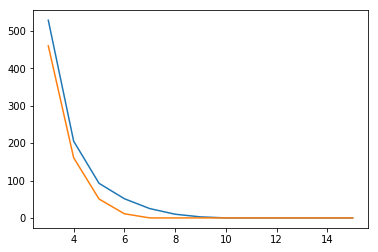

In [61]:
Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',20,1)
num_extra_bins=7
test1=Dia_Kaufmann(Data_test3,64,"even","tree",extra_bins=num_extra_bins)
test2=Dia_Kaufmann(Data_test3,64,"percentile","tree",extra_bins=num_extra_bins)
plt.plot(range(3,9+num_extra_bins), test1.entropy(2)[0][2:],range(3,9+num_extra_bins), test2.entropy(2)[0][2:])

[<matplotlib.lines.Line2D object at 0x0000019BB6B4C780>, <matplotlib.lines.Line2D object at 0x0000019BB6B4C588>]

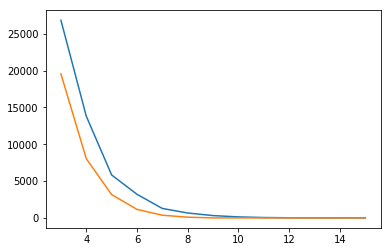

In [58]:
Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',100,1)
num_extra_bins=7
test1=Dia_Kaufmann(Data_test3,64,"even","tree",extra_bins=num_extra_bins)
test2=Dia_Kaufmann(Data_test3,64,"percentile","tree",extra_bins=num_extra_bins)
plt.plot(range(3,9+num_extra_bins), test1.entropy(2)[0][2:],range(3,9+num_extra_bins), test2.entropy(2)[0][2:])

[<matplotlib.lines.Line2D object at 0x0000019BB7085B00>, <matplotlib.lines.Line2D object at 0x0000019BB7085C50>]

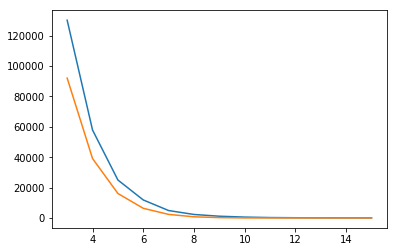

In [60]:
Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',200,1)
num_extra_bins=7
test1=Dia_Kaufmann(Data_test3,64,"even","tree",extra_bins=num_extra_bins)
test2=Dia_Kaufmann(Data_test3,64,"percentile","tree",extra_bins=num_extra_bins)
plt.plot(range(3,9+num_extra_bins), test1.entropy(2)[0][2:],range(3,9+num_extra_bins), test2.entropy(2)[0][2:])

# Multiple MS2 to MS1 observations

[<matplotlib.lines.Line2D object at 0x0000019BB7951630>, <matplotlib.lines.Line2D object at 0x0000019BB7951780>]

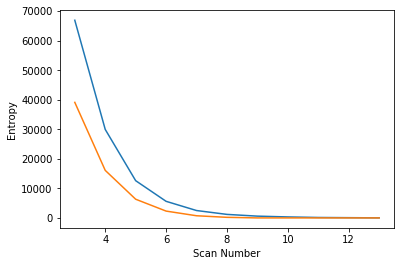

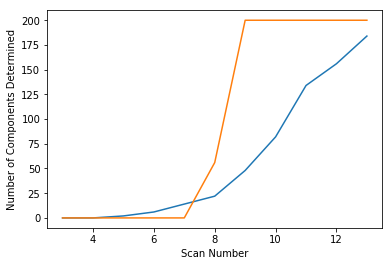

In [81]:
Data_test3=Sample_Dataset('../../../beer_data/peak_sampler_4_beers.p',100,2)
num_extra_bins=5
test1=Dia_Kaufmann(Data_test3,64,"even","tree",extra_bins=num_extra_bins)
test2=Dia_Kaufmann(Data_test3,64,"percentile","tree",extra_bins=num_extra_bins)
plt.figure(0)
plt.xlabel('Scan Number')
plt.ylabel('Entropy')
plt.plot(range(3,9+num_extra_bins), test1.entropy(2)[0][2:],range(3,9+num_extra_bins), test2.entropy(2)[0][2:])
plt.figure(1)
plt.xlabel('Scan Number')
plt.ylabel('Number of Components Determined')
plt.plot(range(3,9+num_extra_bins), test1.entropy(2)[1][2:],range(3,9+num_extra_bins), test2.entropy(2)[1][2:])

Note : Bin walls doesnt seem to come out correctly, but entropy still works